In [1]:
import numpy as np
import random
import os

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf 

tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
from plot_module import save_plot

import pandas as pd  
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

### Loading data and preprocessing

In [3]:
df = pd.read_csv('Monthly_oil_data.csv', index_col='Production Date', parse_dates=True)
df['LogVolume'] = np.log(df['Volume']) 
df['DiffLogVolume'] = df['LogVolume'].diff() 
df.head()

,Volume,LogVolume,DiffLogVolume
Production Date,,,
2015-01-01,67515553.0,18.027869,NaN
2015-02-01,61664960.0,17.937226,-0.090642
2015-03-01,66342950.0,18.010348,0.073122
2015-04-01,67719040.0,18.030878,0.020530
2015-05-01,66484591.0,18.012481,-0.018397


### Supervised Dataset

In [4]:
series = df['DiffLogVolume'].to_numpy()[1:] 

T = 6
X = [] 
Y = []  
for t in range(len(series) - T):
    x = series[t:t+T] 
    X.append(x) 
    y = series[t+T] 
    Y.append(y)

X = np.array(X).reshape(-1, T) 
Y = np.array(Y)
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (118, 6) Y.shape (118,)


### Train Test Split

In [5]:
Ntest = 12
train = df.iloc[:-Ntest] 
test = df.iloc[-Ntest:] 

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest] 
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Scaling

In [6]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

Xtrain = scaler_x.fit_transform(Xtrain)
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)

Xtest = scaler_x.transform(Xtest)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

Ytrain = scaler_y.fit_transform(Ytrain.reshape(-1, 1))
Ytest = scaler_y.transform(Ytest.reshape(-1, 1))

### Indexing

In [7]:
train_idx = df.index <= train.index[-1] 
test_idx = ~train_idx 

### RNN

In [8]:
model = Sequential([
    Input(shape=(T, 1)),
    LSTM(40, activation='tanh', return_sequences=True),
    Dropout(0.1),
    LSTM(40, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 40)               │           6,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 40)                  │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,721 (77.04 KB)

 Trainable params: 19,721 (77.04 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
r = model.fit(
    Xtrain, 
    Ytrain,
    epochs=100,
    batch_size=16,
    validation_data=(Xtest, Ytest),
    verbose=1,
    shuffle=False
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.2483 - val_loss: 0.2142
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2327 - val_loss: 0.2000
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2189 - val_loss: 0.1865
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2040 - val_loss: 0.1736
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1901 - val_loss: 0.1612
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1782 - val_loss: 0.1492
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1650 - val_loss: 0.1376
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1522 - val_loss: 0.1263
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1407 - val_loss: 0.1152
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1281 - val_loss: 0.1044
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1168 - val_loss: 0.0938
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1065 - val_l

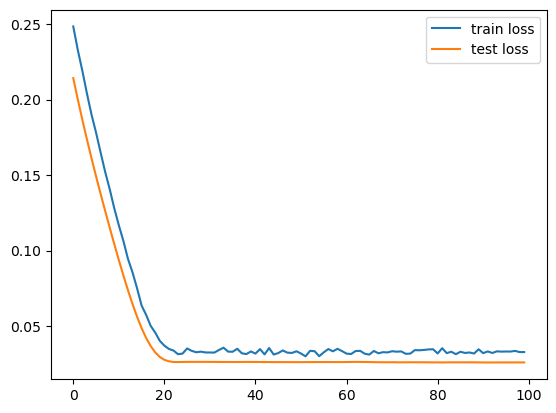

In [11]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [12]:
train_idx[:T+1] = False # first T+1 values are not predictable

Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

print(Ptrain.shape, Ptest.shape)

Ptrain = scaler_y.inverse_transform(Ptrain.reshape(-1, 1)).flatten()
Ptest = scaler_y.inverse_transform(Ptest.reshape(-1, 1)).flatten()

# needed to compute un-differenced predictions 
df['ShiftLogVolume'] = df['LogVolume'].shift(1) 
prev = df['ShiftLogVolume']

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(106,) (12,)


### 1-step forecast

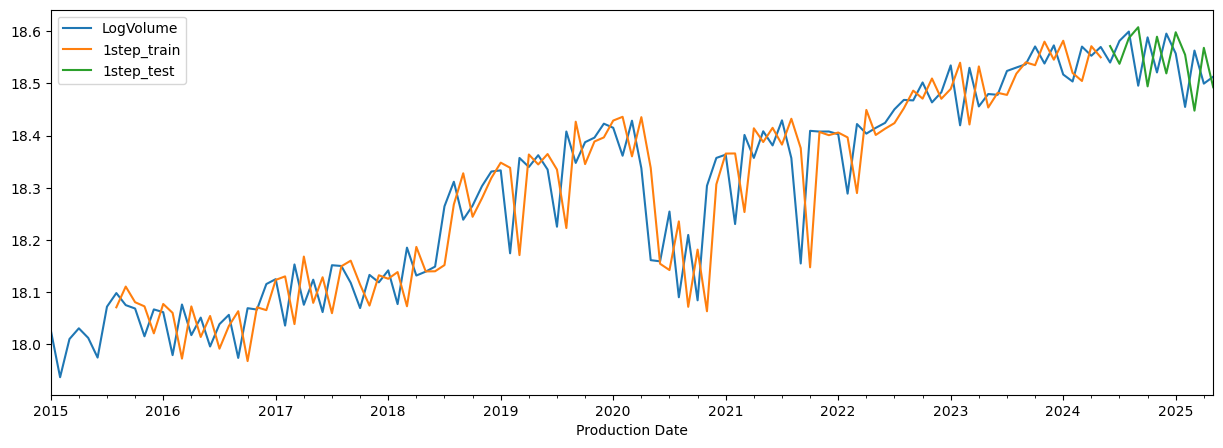

In [13]:
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain 
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest 

# plot 1-step forecast
df[['LogVolume', '1step_train', '1step_test']].plot(figsize=(15,5));

### Multi-step forecast

In [14]:
multistep_predictions = [] 

# first test input
last_x = Xtest[0] 

while len(multistep_predictions) < Ntest: 
    p = model.predict(last_x[np.newaxis, :, :], verbose=0)  
    p_value = p[0, 0]
    # update predictions list 
    multistep_predictions.append(p_value) 
    # make the new input 
    last_x = np.roll(last_x, -1) 
    last_x[-1, 0] = p_value

multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler_y.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten() 
# last-known train value 
last_train = train.iloc[-1]['LogVolume']

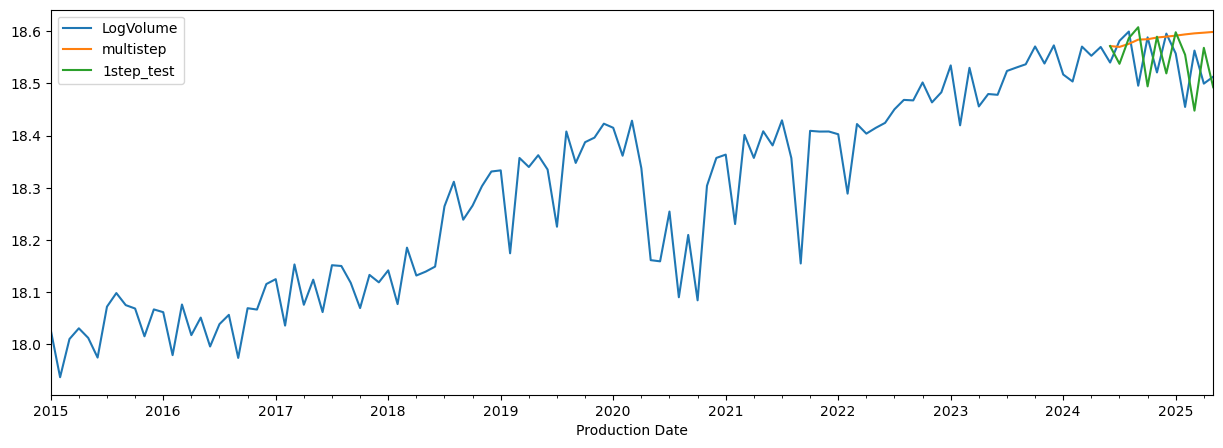

In [15]:
# multi-step forecast 
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions) 

df[['LogVolume', 'multistep', '1step_test']].plot(figsize=(15,5));

### Multi-output supervised dataset

In [16]:
Tx = T 
Ty = Ntest 
X = [] 
Y = [] 

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx) 
Y = np.array(Y).reshape(-1, Ty) 
N = len(X) 
print('X.shape', X.shape, 'Y.shape', Y.shape)

X.shape (107, 6) Y.shape (107, 12)


### Train/Test Split

In [17]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1] 
Xtest_m, Ytest_m = X[-1:], Y[-1:]

### Scaling

In [18]:
scaler_xm = MinMaxScaler(feature_range=(0, 1))
scaler_ym = MinMaxScaler(feature_range=(0, 1))

Xtrain_m = scaler_xm.fit_transform(Xtrain_m)
Xtrain_m = Xtrain_m.reshape(-1, Xtrain_m.shape[1], 1)

Xtest_m = scaler_xm.transform(Xtest_m)
Xtest_m = Xtest_m.reshape(-1, Xtest_m.shape[1], 1)

Ytrain_m = scaler_ym.fit_transform(Ytrain_m)
Ytest_m = scaler_ym.transform(Ytest_m)

### RNN

In [19]:
model = Sequential([
    Input(shape=(T, 1)),
    LSTM(40, activation='tanh', return_sequences=True),
    Dropout(0.1),
    LSTM(40, activation='tanh'),
    Dropout(0.1),
    Dense(Ty)
])

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse'
)

In [21]:
r = model.fit(
    Xtrain_m, 
    Ytrain_m,
    epochs=100,
    batch_size=16,
    validation_data=(Xtest_m, Ytest_m),
    #callbacks=[check_point],
    verbose=1,
    shuffle=False
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.1268 - val_loss: 0.0331
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0495 - val_loss: 0.0292
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0371 - val_loss: 0.0270
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0350 - val_loss: 0.0281
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0337 - val_loss: 0.0249
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0330 - val_loss: 0.0239
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0326 - val_loss: 0.0241
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0324 - val_loss: 0.0252
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0322 - val_loss: 0.0246
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0324 - val_loss: 0.0254
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0324 - val_loss: 0.0247
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0322 - val_l

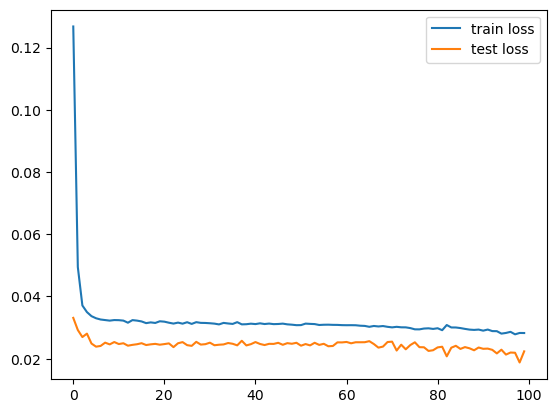

In [22]:
plt.plot(r.history['loss'], label='train loss') 
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

### Make Predictions

In [23]:
Ptrain_m = model.predict(Xtrain_m) 
Ptest_m = model.predict(Xtest_m)

print(Ptrain_m.shape, Ptest_m.shape)
print("Raw predictions (first 3 samples, first 3 steps):")
print(Ptest_m[:3, :3])
print(f"Mean of predictions: {Ptest_m.mean()}")
print(f"Std of predictions: {Ptest_m.std()}")

# Before inverse transform
print("Before inverse transform:", Ptest_m[:2, :2])

# After inverse transform
Ptest_m_original = scaler_ym.inverse_transform(Ptest_m)
print("After inverse transform:", Ptest_m_original[:2, :2]) 

Ptrain_m = scaler_ym.inverse_transform(Ptrain_m) 
Ptest_m = scaler_ym.inverse_transform(Ptest_m) 

Ptrain_m = Ptrain_m[:,0] 
Ptest_m = Ptest_m[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(106, 12) (1, 12)
Raw predictions (first 3 samples, first 3 steps):
[[0.43377888 0.46563143 0.41589546]]
Mean of predictions: 0.4436616599559784
Std of predictions: 0.028446167707443237
Before inverse transform: [[0.43377888 0.46563143]]
After inverse transform: [[-0.00408002  0.01043602]]


### Multi-output forecast

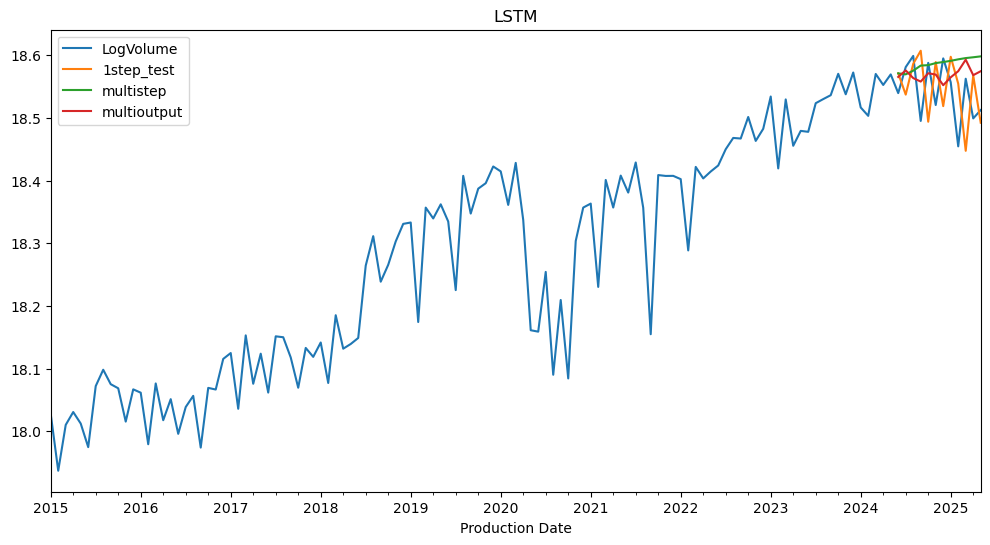

In [24]:
# multi-output forecast 
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest_m)

ax = df.plot(y=['LogVolume','1step_test',  'multistep', 'multioutput'], figsize=(12,6))
ax.set_title('LSTM')

fig = ax.get_figure()
save_plot(fig, 'LSTM')

### MAPE

In [25]:
test_log_pass = df.iloc[-Ntest:]['LogVolume'] 
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print('multi-step MAPE:', mape1) 
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print('multi-output MAPE:', mape2) 
#mape3 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput2'])
#print('multi-output(2 LSTMs) MAPE:', mape3)

multi-step MAPE: 0.002793669916002016
multi-output MAPE: 0.002368885559793979
